In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [62]:
unknown_df= pd.read_csv(r"D:\Github\Data_Mining_113-2\Data_Mining_Final\classification\result\KNN_unknown.csv")
ids = unknown_df.iloc[:, 0]
X = np.array(unknown_df.iloc[:, 1:])
print(ids)
print(X)

0      sample_189
1      sample_320
2      sample_288
3        sample_6
4       sample_13
          ...    
217    sample_788
218    sample_794
219    sample_798
220    sample_799
221    sample_800
Name: id, Length: 222, dtype: object
[[ 0.41294407  2.69630547  3.28818135 ...  9.14306428  4.26506177
   0.        ]
 [ 0.          3.09000653  3.52619404 ...  9.81024064  5.86081882
   1.58688481]
 [ 0.          1.78663818  1.7684596  ...  9.91253461  8.25696817
   0.        ]
 ...
 [ 0.          3.24958187  3.70749166 ...  9.46671072  4.6774575
   0.5866927 ]
 [ 0.          2.59033853  2.78797567 ... 10.40058062  5.71875068
   0.        ]
 [ 0.          2.32524248  3.80593214 ...  9.84479363  4.55071601
   0.        ]]


263.9840411573574
Weighted Matrix:


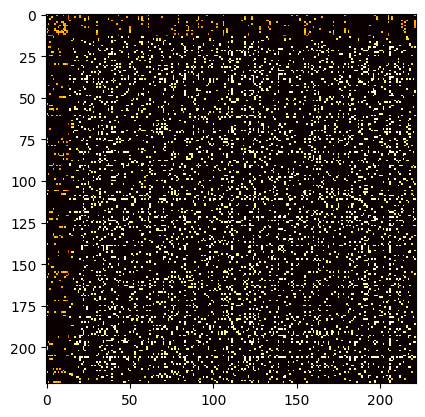

In [50]:
# Step 1: Compute all pairwise squared distances
n = len(X)
distances = []
for i in range(n):
    for j in range(i+1, n):  # avoid duplicates and self-distances
        dist = np.sum((X[i] - X[j])**2)
        distances.append(dist)
sigma = np.sqrt(np.median(distances))  # we take sqrt to get back to Euclidean scale
print(sigma)

k_neighbors = 15
num_clusters = 2
max_iter = 100

# ----------------------------
# Step 2: Weighted k-NN Graph (W)
# ----------------------------
def similarity(x1, x2, sigma=1.0):
    return np.exp(-np.sum((x1 - x2)**2) / (2 * sigma**2))
n = len(X)
dist_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        dist_matrix[i, j] = np.sum((X[i] - X[j])**2)

neighbors = np.argsort(dist_matrix, axis=1)[:, 1:k_neighbors+1]

W = np.zeros((n, n))
for i in range(n):
    for j in neighbors[i]:
        W[i, j] = similarity(X[i], X[j], sigma)
print("Weighted Matrix:")

W = np.maximum(W, W.T)  # Symmetrize
plt.imshow(W, cmap='hot', interpolation='nearest')



Laplacian Matrix:
[[11.87499388 -0.62390945  0.         ...  0.          0.
   0.        ]
 [-0.62390945 10.05135982  0.         ...  0.          0.
  -0.59719971]
 [ 0.          0.          9.12178227 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  9.64220587  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         15.43547496
   0.        ]
 [ 0.         -0.59719971  0.         ...  0.          0.
  17.43626387]]


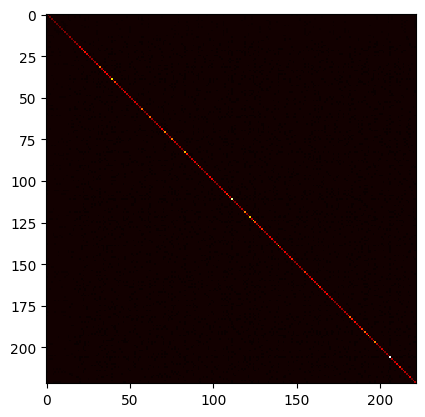

In [51]:
# ----------------------------
# Step 3: Laplacian Matrix (L = D - W)
# ----------------------------
D = np.diag(np.sum(W, axis=1))
L = D - W
print("Laplacian Matrix:")
print(L)
plt.imshow(L, cmap='hot', interpolation='nearest')

# ----------------------------
# Step 4: Eigen Decomposition
# ----------------------------
e_vals, e_vecs = np.linalg.eigh(L)

# Take first `num_clusters` smallest eigenvectors
embedding = e_vecs[:, :num_clusters]

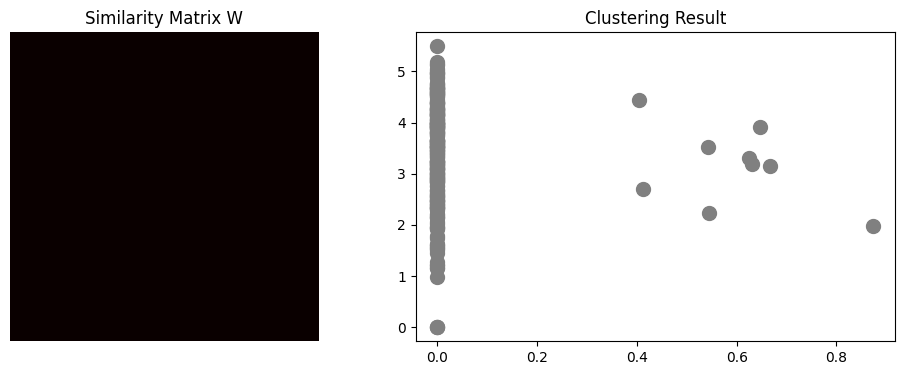

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# -------------------------------
# Sample dataset
# -------------------------------
n = len(X)
sigmas = np.linspace(0.1, 10, 50)  # test 50 sigma values

# -------------------------------
# Similarity function
# -------------------------------
def similarity(x1, x2, sigma):
    return np.exp(-np.sum((x1 - x2)**2) / (2 * sigma**2))

# -------------------------------
# Laplacian + Spectral Clustering
# -------------------------------
def spectral_clustering(X, sigma, k=2):
    # Build full W
    W = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                W[i, j] = similarity(X[i], X[j], sigma)
    W = np.maximum(W, W.T)

    D = np.diag(np.sum(W, axis=1))
    L = D - W
    e_vals, e_vecs = np.linalg.eigh(L)
    U = e_vecs[:, :k]  # first k eigenvectors

    # Run simple K-means (1 iteration, for speed)
    np.random.seed(0)
    centers = U[np.random.choice(n, k, replace=False)]
    dists = np.linalg.norm(U[:, None, :] - centers, axis=2)
    labels = np.argmin(dists, axis=1)

    return W, labels

# -------------------------------
# Animation setup
# -------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 = axes
title = fig.suptitle("")

scatter = ax2.scatter(X[:, 0], X[:, 1], c='gray', s=100)
im = ax1.imshow(np.zeros((n, n)), cmap='hot', vmin=0, vmax=1)
ax1.set_title("Similarity Matrix W")
ax1.axis('off')
ax2.set_title("Clustering Result")

def update(frame):
    sigma = sigmas[frame]
    W, labels = spectral_clustering(X, sigma)
    im.set_data(W)
    scatter.set_array(labels)
    title.set_text(f"Spectral Clustering at σ = {sigma:.2f}")
    return [im, scatter]

ani = FuncAnimation(fig, update, frames=len(sigmas), interval=150, blit=False)

plt.tight_layout()
plt.show()


In [65]:
ani.save("animation.gif", writer='pillow', fps=10)


In [83]:
n = len(X)
import os

output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)
sigmas = np.linspace(100, 300, 10)
def similarity(x1, x2, sigma):
    return np.exp(-np.sum((x1 - x2)**2) / (2 * sigma**2))

def spectral_clustering(X, sigma, k=2):
    W = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                W[i, j] = similarity(X[i], X[j], sigma)
    W = np.maximum(W, W.T)
    D = np.diag(np.sum(W, axis=1))
    L = D - W
    e_vals, e_vecs = np.linalg.eigh(L)
    U = e_vecs[:, :k]
    centers = U[np.random.choice(n, k, replace=False)]
    dists = np.linalg.norm(U[:, None, :] - centers, axis=2)
    labels = np.argmin(dists, axis=1)
    return dists, W, labels

# Save each frame
for i, sigma in enumerate(sigmas):
    dists, W, labels = spectral_clustering(X, sigma)
    print(labels)
    fig, axes = plt.subplots(1, 1, figsize=(10, 4))
    ax1 = axes
    ax1.imshow(W, cmap='hot', vmin=0, vmax=1)
    ax1.set_title(f"W (σ = {sigma:.2f})")
    ax1.axis('off')
    filename = os.path.join(output_dir, f"frame_{i:03d}.png")
    plt.savefig(filename)
    plt.close(fig)

print("✅ All frames saved to:", output_dir)

[1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1]
[0 1 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1
 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1 0
 1 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1
 0 0 1 1 0 1 0 1 1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0
 1 1 0 0 1 0 1 0 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 0 1]
[0 1 1 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 